In [1]:
%pylab inline
from argparse import Namespace
import random
import torch
from tasks.copy import TaskCopy
import numpy as np

## Marcos
RANDOM_SEED = 1000

Populating the interactive namespace from numpy and matplotlib


In [2]:
def init_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

## Copy

In [3]:
args = Namespace(
    batch = 48000,
    seed = RANDOM_SEED,
    task = 'copy',
    seq_width = 8,
    ctrl_size = 100,
    ctrl_num_layers = 1,
    mem_size = 128,
    mem_dim = 20,
    num_heads = 1,
    batch_size = 1,
    mark = 'sun',
)
init_seed(args.seed)


task = TaskCopy(vars(args),'eval')
print(task.net)

log/copy/sun/48000.model
NTM(
  (controller): LSTMController(
    (lstm): LSTM(28, 100)
  )
  (memory): NTMMemory()
  (heads): ModuleList(
    (0): NTMReadHead(
      (memory): NTMMemory()
      (fc_read): Linear(in_features=100, out_features=26, bias=True)
    )
    (1): NTMWriteHead(
      (memory): NTMMemory()
      (fc_write): Linear(in_features=100, out_features=66, bias=True)
    )
  )
  (fc): Linear(in_features=28, out_features=8, bias=True)
)


In [17]:
SEQ_LEN = 30
memory_ls = list()
read_weights = torch.Tensor(2*SEQ_LEN+1,args.mem_size)
write_weights = torch.Tensor(2*SEQ_LEN+1,args.mem_size)
for X,y in task._data_gen(1,1,SEQ_LEN):
    pred = torch.Tensor(y.size())
    task.net.init(1)
    memory_ls.append(task.net.memory.get_memory().t())
    for i in range(SEQ_LEN+1):
        _,prev_state = task.net(X[i])
        read_weights[i] = prev_state[2][0]
        write_weights[i] = prev_state[2][1]
    memory_ls.append(task.net.memory.get_memory().t())
    for o in range(SEQ_LEN):
        pred[o],prev_state = task.net(torch.zeros(1,task.seq_width))
        read_weights[o+SEQ_LEN+1] = prev_state[2][0]
        write_weights[o+SEQ_LEN+1] = prev_state[2][1]
    memory_ls.append(task.net.memory.get_memory().t())
    y = torch.transpose(y,0,2)
    pred = torch.transpose(pred,0,2)

Cost per byte: 0.0


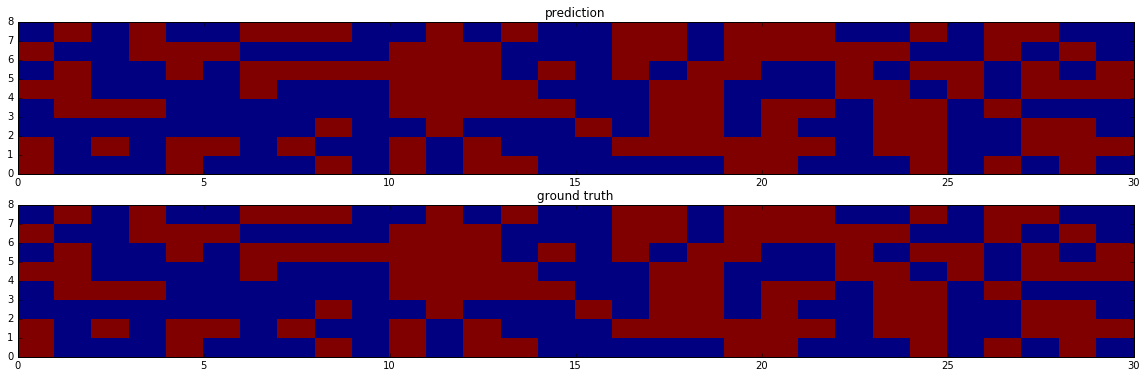

In [18]:
plt.figure(figsize=(20, 6))
plt.subplot(2,1, 1)
plt.title("prediction")
pcolormesh(pred.squeeze(1).data.numpy())
plt.subplot(2,1, 2)
plt.title("ground truth")
pcolormesh(y.squeeze(1).data.numpy())
print("Cost per byte: {}".format(torch.sum(torch.abs(torch.round(pred)-y))/(SEQ_LEN)))

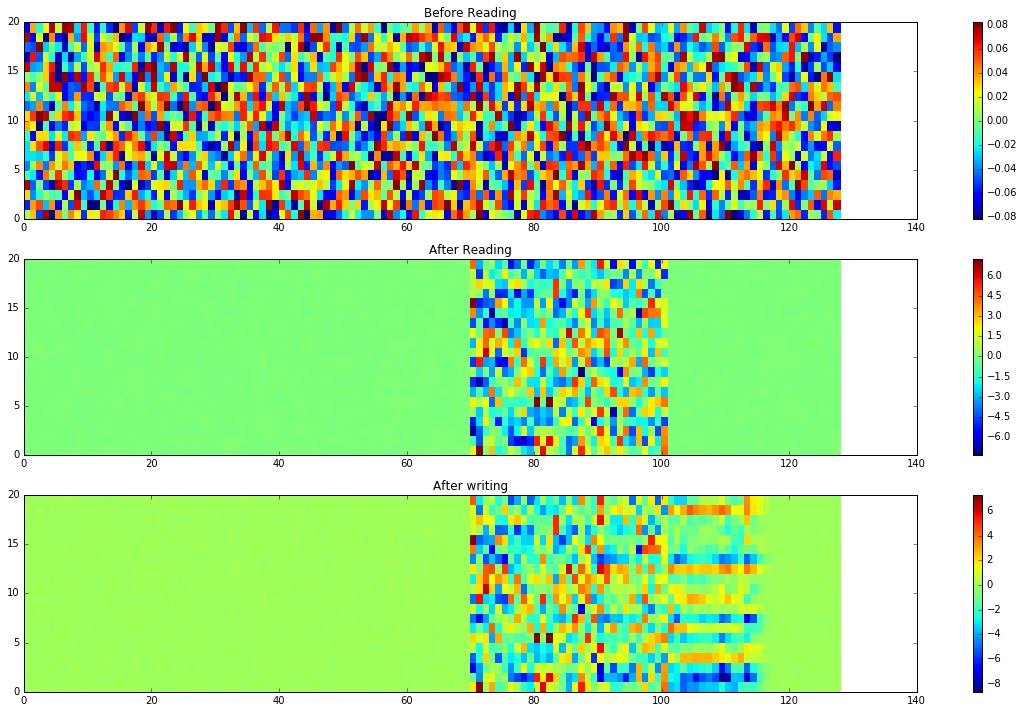

In [19]:
plt.figure(figsize=(20, 12))
plt.subplot(3,1, 1)
plt.title("Before Reading")
pcolormesh(memory_ls[0].data.numpy())
plt.colorbar()
plt.subplot(3,1, 2)
plt.title("After Reading")
pcolormesh(memory_ls[1].data.numpy())
plt.colorbar()
plt.subplot(3,1, 3)
plt.title("After writing")
pcolormesh(memory_ls[2].data.numpy())
plt.colorbar()

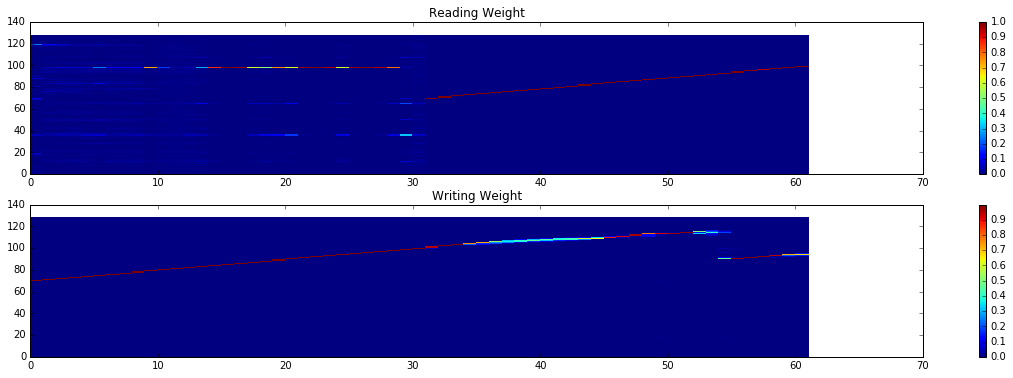

In [20]:
plt.figure(figsize=(20, 6))
plt.subplot(2,1, 1)
plt.title("Reading Weight")
pcolormesh(read_weights.t().data.numpy())
plt.colorbar()
plt.subplot(2,1, 2)
plt.title("Writing Weight")
pcolormesh(write_weights.t().data.numpy())
plt.colorbar()

R/W weight 對應到其在 memory bank 的位置。

In [21]:
SEQ_LEN = 120
memory_ls = list()
read_weights = torch.Tensor(2*SEQ_LEN+1,args.mem_size)
write_weights = torch.Tensor(2*SEQ_LEN+1,args.mem_size)
for X,y in task._data_gen(1,1,SEQ_LEN):
    pred = torch.Tensor(y.size())
    task.net.init(1)
    memory_ls.append(task.net.memory.get_memory().t())
    for i in range(SEQ_LEN+1):
        _,prev_state = task.net(X[i])
        read_weights[i] = prev_state[2][0]
        write_weights[i] = prev_state[2][1]
    memory_ls.append(task.net.memory.get_memory().t())
    for o in range(SEQ_LEN):
        pred[o],prev_state = task.net(torch.zeros(1,task.seq_width))
        read_weights[o+SEQ_LEN+1] = prev_state[2][0]
        write_weights[o+SEQ_LEN+1] = prev_state[2][1]
    memory_ls.append(task.net.memory.get_memory().t())
    y = torch.transpose(y,0,2)
    pred = torch.transpose(pred,0,2)

Cost per byte: 1.4666666984558105


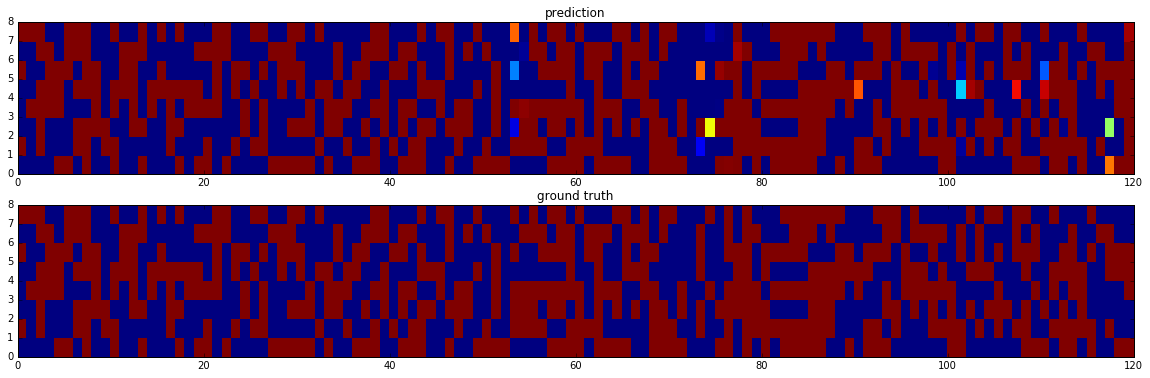

In [22]:
plt.figure(figsize=(20, 6))
plt.subplot(2,1, 1)
plt.title("prediction")
pcolormesh(pred.squeeze(1).data.numpy())
plt.subplot(2,1, 2)
plt.title("ground truth")
pcolormesh(y.squeeze(1).data.numpy())
print("Cost per byte: {}".format(torch.sum(torch.abs(torch.round(pred)-y))/(SEQ_LEN)))

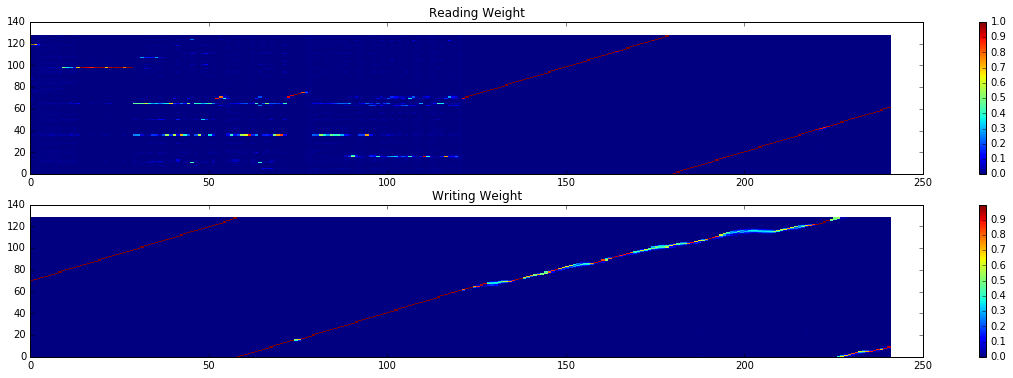

In [23]:
plt.figure(figsize=(20, 6))
plt.subplot(2,1, 1)
plt.title("Reading Weight")
pcolormesh(read_weights.t().data.numpy())
plt.colorbar()
plt.subplot(2,1, 2)
plt.title("Writing Weight")
pcolormesh(write_weights.t().data.numpy())
plt.colorbar()

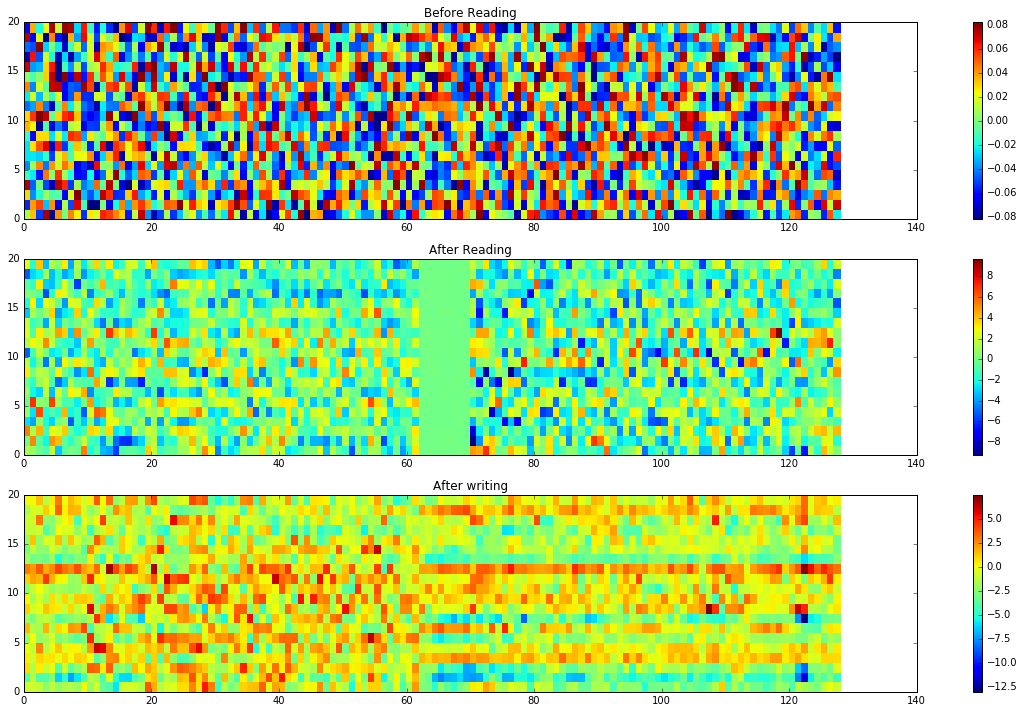

In [24]:
plt.figure(figsize=(20, 12))
plt.subplot(3,1, 1)
plt.title("Before Reading")
pcolormesh(memory_ls[0].data.numpy())
plt.colorbar()
plt.subplot(3,1, 2)
plt.title("After Reading")
pcolormesh(memory_ls[1].data.numpy())
plt.colorbar()
plt.subplot(3,1, 3)
plt.title("After writing")
pcolormesh(memory_ls[2].data.numpy())
plt.colorbar()

**Remark:** 可以看得出其是 sequentially 地使用 memory bank (而且是從中間的 memory cell 開始用)，而且在 SEQ_LEN 會有 R/W mode 切換！

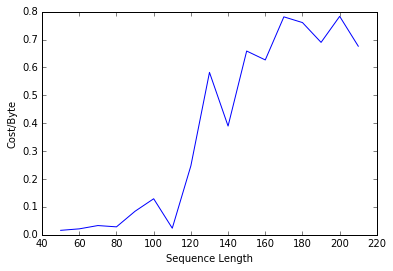

In [4]:
TEST_NUM = 5
cost_ls = []
for seq_len in range(50,220,10):
    cost = 0.0
    for X,y in task._data_gen(TEST_NUM,1,seq_len):
        pred = torch.Tensor(y.size())
        task.net.init(1)
        for i in range(seq_len+1):
            task.net(X[i])
        for o in range(seq_len):
            pred[o],_ = task.net(torch.zeros(1,task.seq_width))
        y = torch.transpose(y,0,2)
        pred = torch.transpose(pred,0,2)
        cost += torch.sum(torch.abs(torch.round(pred)-y))/(seq_len*TEST_NUM)
    cost /= TEST_NUM
    cost_ls.append(cost)
plt.xlabel('Sequence Length')
plt.ylabel('Cost / Byte')
plot(range(50,220,10),cost_ls)

In general, 根據 memory bank 的大小， bottleneck length 落在 120 附近，但他也不是一口氣爛光，還是會 maintain 那些它可以記的